# LIBRARIES

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# DATA

## Loading

In [8]:
%cd /home/think/Desktop/5x4_sample

/home/think/Desktop/5x4_sample


In [ ]:
all_x20 = pd.read_csv('5x4_df_samples.csv')
all_x20.drop(all_x20.columns[[0]], axis=1, inplace=True)
all_x20.head()

,id,x,y,z
0,1,0.100000,0.100000,0.100000
1,1,0.097913,0.101250,0.096328
2,1,0.095850,0.102482,0.092863
3,1,0.093809,0.103694,0.089594
4,1,0.091790,0.104888,0.086511


In [10]:
lookup_x20 = pd.read_csv('5x4_df_lookup.csv')
lookup_x20.drop(lookup_x20.columns[[0]], axis=1, inplace=True)
lookup_x20.head()

,id,sample_name,ic_x,ic_y,ic_z,params
0,1,rossler,0.1,0.1,0.1,"{'a': 0.2, 'b': 0.2, 'c': 5.7}"
1,2,rossler,0.2,0.2,0.2,"{'a': 0.2, 'b': 0.2, 'c': 5.7}"
2,3,rossler,0.3,0.3,0.3,"{'a': 0.2, 'b': 0.2, 'c': 5.7}"
3,4,rossler,0.4,0.4,0.4,"{'a': 0.2, 'b': 0.2, 'c': 5.7}"
4,5,lorenz63,0.1,0.1,0.1,"{'sigma': 10, 'beta': 2.6666666666666665, 'rho..."


In [11]:
#rossler_sample_1 = all_x20[all_x20['id'] == 1].copy()
#rossler_sample_1 = all_x20.loc[ all_x20['id'] == 1, ['x', 'y'] ].copy()
rossler_sample_1 = all_x20.loc[ all_x20['id'] == 1, ['x'] ].copy()

In [12]:
rossler_sample_1

,x
0,0.100000
1,0.097913
2,0.095850
3,0.093809
4,0.091790
...,...
9995,-3.812888
9996,-3.773334
9997,-3.733280
9998,-3.692730


## Scaling

In [13]:
# Apply a MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rossler_sample_1_scaled = pd.DataFrame(scaler.fit_transform(rossler_sample_1), columns = ['x'])

In [14]:
rossler_sample_1_scaled

,x
0,0.448117
1,0.448015
2,0.447914
3,0.447815
4,0.447717
...,...
9995,0.257544
9996,0.259470
9997,0.261421
9998,0.263396


## Visualization

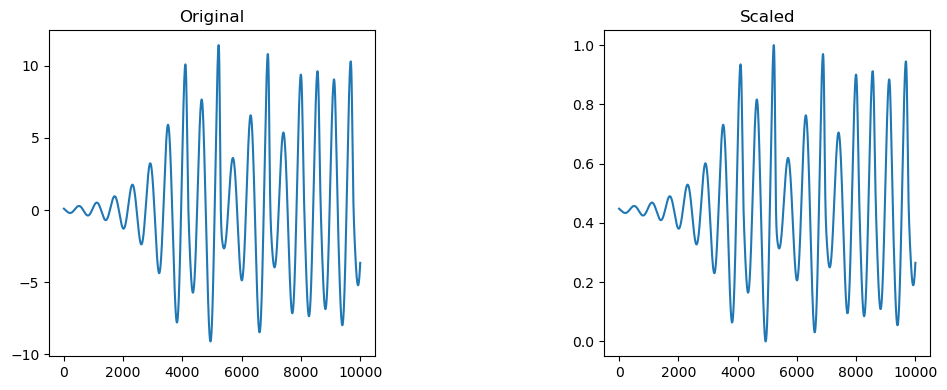

In [15]:
# import matplotlib.pyplot as plt

# # Calculate global min and max for y-axis limits
# y_min = min(rossler_sample_1['x'].min(), rossler_sample_1_scaled['x'].min())
# y_max = max(rossler_sample_1['x'].max(), rossler_sample_1_scaled['x'].max())

# # Create subplots
# fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# # Plot original
# rossler_sample_1['x'].plot(ax=axs[0], title='Original')
# axs[0].set_ylim(y_min, y_max)

# # Plot scaled
# rossler_sample_1_scaled['x'].plot(ax=axs[1], title='Scaled')
# axs[1].set_ylim(y_min, y_max)

# plt.tight_layout()
# plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot original
rossler_sample_1['x'].plot(ax=axs[0], title='Original')
# Plot scaled
rossler_sample_1_scaled['x'].plot(ax=axs[1], title='Scaled')

# Let each subplot auto-scale its own y-axis
# But make sure they use the same "physical size" vertically
for ax in axs:
    ax.set_box_aspect(1)  # Makes both plots square in aspect ratio

plt.tight_layout()
plt.show()


## Training and Test Split

### Truncation, Is it that relevant?

In [16]:
# Count decimal digits per value
decimal_lengths = rossler_sample_1_scaled['x'].apply(lambda v: len(str(v).split('.')[-1]) if '.' in str(v) else 0)

# Check if all are the same
unique_lengths = decimal_lengths.unique()

print("Unique decimal lengths:", unique_lengths)

if len(unique_lengths) == 1:
    print(f"✅ All values have {unique_lengths[0]} digits after the decimal.")
else:
    print("❌ Values have varying decimal lengths.")

Unique decimal lengths: [16 17 15 13 14 18 19 20  1 12]
❌ Values have varying decimal lengths.


In [17]:
Full = rossler_sample_1_scaled['x'].values

In [18]:
n_samples = len(Full)
train_size = int(0.90 * n_samples)

train_data = Full[:train_size]
test_data = Full[train_size:]


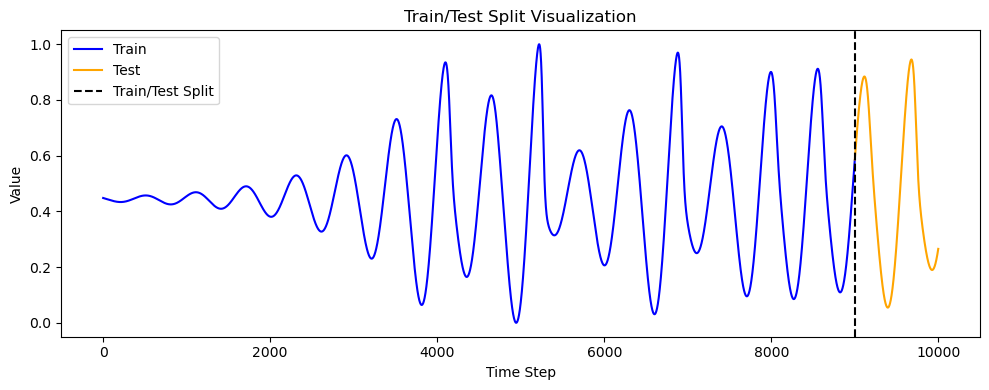

In [19]:
# Define x-axis ranges based on the lengths
train_end = len(train_data)
x_train = np.arange(train_end)
x_test = np.arange(train_end, train_end + len(test_data))
# Plot
plt.figure(figsize=(10, 4))
plt.plot(x_train, train_data, label='Train', color='blue')
plt.plot(x_test, test_data, label='Test', color='orange')

# Optional vertical line to indicate the split
plt.axvline(x=train_end, color='black', linestyle='--', label='Train/Test Split')

plt.legend()
plt.title("Train/Test Split Visualization")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

# CNN

## Univariate One-Step

### Prepare Data for the Model

In [24]:
# univariate data preparation
from numpy import array

#split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i +n_steps
        if end_ix > len(sequence) - 1:
            break
        #gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [25]:
train_data

array([0.44811656, 0.4480149 , 0.44791443, ..., 0.57397513, 0.57807358,
       0.58216545])

In [26]:
# choose a number of time steps
n_steps = 1
# split into samples
X, y = split_sequence(train_data, n_steps)   

In [27]:
X.shape

(8999, 1)

In [28]:
y.shape

(8999,)

In [29]:
# summarize the data
for i in range(len(X)):
    print(X[i],y[i])

[0.44811656] 0.4480149030581577
[0.4480149] 0.4479144317814097
[0.44791443] 0.44781505755579926
[0.44781506] 0.4477166925672069
[0.44771669] 0.4476192540214631
[0.44761925] 0.447522663292553
[0.44752266] 0.44742681150329144
[0.44742681] 0.4473316282211968
[0.44733163] 0.44723706990745105
[0.44723707] 0.44714309354190457
[0.44714309] 0.44704965662307633
[0.44704966] 0.44695671716815405
[0.44695672] 0.4468642337129939
[0.44686423] 0.4467721653121208
[0.44677217] 0.4466804715387281
[0.44668047] 0.44658911248467786
[0.44658911] 0.4464980487605008
[0.44649805] 0.4464072414953961
[0.44640724] 0.4463166523372317
[0.44631665] 0.44622624345254397
[0.44622624] 0.446135977526538
[0.44613598] 0.44604581776308744
[0.44604582] 0.4459557278847346
[0.44595573] 0.4458656721326903
[0.44586567] 0.4457756162096066
[0.44577562] 0.4456855649006787
[0.44568556] 0.4455955230453022
[0.44559552] 0.4455054817659285
[0.44550548] 0.44541543243785736
[0.44541543] 0.4453253666892367
[0.44532537] 0.445235276401063
[0

In [30]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [31]:
X.shape

(8999, 1, 1)

### Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

In [96]:
# define model
model = Sequential()
model.add(Conv1D(64, kernel_size=1, activation = 'relu', input_shape=(n_steps, n_features)))
#model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [97]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
]

In [ ]:
history = model.fit(X, y,
                    epochs=300,
                    batch_size=64,
                    validation_split=0.1,
                    shuffle=False,
                    callbacks=callbacks,
                    verbose=1)

### Save Model

In [65]:
import os
import json
import joblib
import tensorflow as tf
from pathlib import Path

def save_experiment(model, history, scaler=None,
                    name="experiment", save_dir=None,
                    use_h5=False):
    """
    Save model + history + optional scaler in {save_dir}/{name}/
    Options:
      - use_h5=True → HDF5 (.h5) single file
      - use_h5=False → Keras 3 format (.keras single file)
    """
    base = Path(save_dir or os.getcwd()) / name
    base.mkdir(parents=True, exist_ok=True)

    if use_h5:
        model_path = base / f"{name}.h5"
        model.save(model_path, save_format='h5')
        print(f"[+] Saved HDF5 model to {model_path.name}")
    else:
        model_path = base / f"{name}.keras"
        model.save(model_path)  # defaults to Keras v3 format
        print(f"[+] Saved Keras model to {model_path.name}")

    # Save history
    with open(base / "history.json", "w") as f:
        json.dump(history.history, f)

    # Save scaler
    if scaler is not None:
        joblib.dump(scaler, base / "scaler.pkl")

    return base, model_path

In [146]:
save_experiment(
  model, history,
  name="CNN_OS_UV_1",
  save_dir="/home/think/Desktop/MODELS",
  use_h5=False
)

[+] Saved Keras model to CNN_OS_UV_1.keras


(PosixPath('/home/think/Desktop/MODELS/CNN_OS_UV_1'),
 PosixPath('/home/think/Desktop/MODELS/CNN_OS_UV_1/CNN_OS_UV_1.keras'))

### Reload Model

In [2]:
import os
import json
import joblib
import tensorflow as tf
from pathlib import Path

In [67]:
def reload_experiment():
    """
    Prompts for folder path, loads:
      - model (.keras or .h5)
      - history.json
      - scaler.pkl (if exists)
    Returns: model, history_dict, scaler
    """
    path = Path(input("Experiment folder path: ").strip()).expanduser()
    base = path / path.name  # prefer file inside named subfolder

    # Find model file
    mfile = next(path.glob("*.keras"), None) or next(path.glob("*.h5"), None)
    if mfile is None:
        raise FileNotFoundError("No `.keras` or `.h5` model found.")

    model = tf.keras.models.load_model(mfile)
    print(f"[+] Loaded model from {mfile.name}")

    # Load history
    history = json.load(open(path / "history.json"))
    print("[+] Loaded history.json")

    # Load scaler
    scaler = None
    skl = path / "scaler.pkl"
    if skl.exists():
        scaler = joblib.load(skl)
        print("[+] Loaded scaler.pkl")

    return model, history, scaler


In [5]:
# /home/think/Desktop/MODELS/CNN_OS_UV_1
model_CNN_UV_OS, history_CNN_UV_OS, scaler__CNN_UV_OS = reload_experiment()

[+] Loaded model from CNN_OS_UV_1.keras
[+] Loaded history.json


### Model Exploration and Testing 

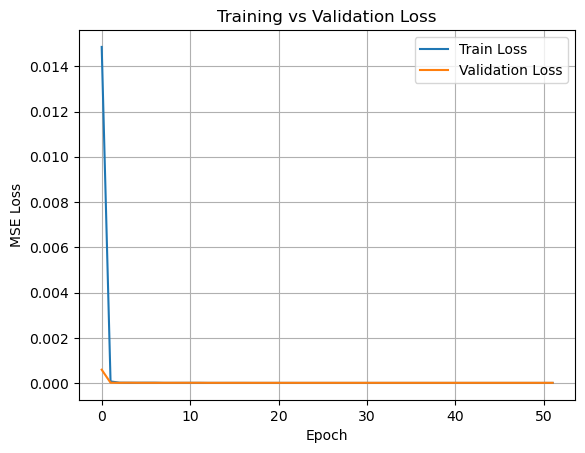

In [6]:
import matplotlib.pyplot as plt

plt.plot(history_CNN_UV_OS['loss'], label='Train Loss')
plt.plot(history_CNN_UV_OS['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

### Exploration Function: Try 1

In [37]:
# demonstrare prediction
x_input = np.array([train_data[-1]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model_CNN_UV_OS.predict(x_input, verbose=0)
print(f'{train_data[-1]} fue introduciod en el modelo')
print(f'{yhat[0,0]} fue predecido para el punto {test_data[0]}')

0.5821654508756415 fue introduciod en el modelo
0.5826485753059387 fue predecido para el punto 0.5862502717122025


In [115]:
from sklearn import metrics
from scipy.stats import skew
import numpy as np

# what we are aiming for
true_data = test_data 
# Initialize input, start with the last value of the training data
uno = train_data[-1]
# reshape so we can feed it to the model
uno = uno.reshape((1, n_steps, n_features)) 
# List to store predictions
predictions = []
# List to record the error evolution
errors = []
# Set a treshold to stop the model wehn it fails
treshold = 1

# Loop to predict one step at a time
for i in range(len(test_data)):
    yhat = model.predict(uno, verbose=0)
    errors.append((true_data[i] - yhat[0, 0])**2)   
    predictions.append(yhat[0, 0])
    
    # update input to next step — use prediction as input
    uno = yhat.reshape((1, n_steps, n_features))

# Convert predictions to numpy array
predictions = np.array(predictions)

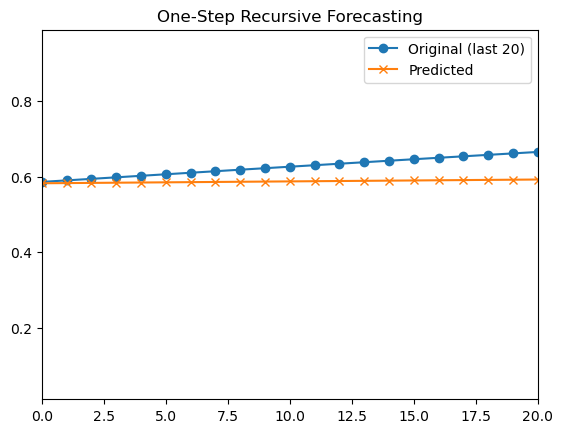

In [116]:
# Plot
plt.plot(test_data, label='Original (last 20)', marker='o')
plt.plot(predictions, label='Predicted', marker='x')
plt.legend()
plt.xlim(0,20)
plt.title('One-Step Recursive Forecasting')
plt.show()

### Exploration Function: TRy 2

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import skew, kurtosis

def recursive_forecast_evaluate(model, train_data, test_data,
                                 n_steps, n_features, threshold):
    """
    Performs recursive multi-step forecasting, computes error metrics,
    and plots results with a failure threshold.
    
    Parameters:
    - model: trained Keras model
    - train_data: array of training values
    - test_data: array of true test values
    - n_steps: input window length
    - n_features: number of features (usually 1)
    - threshold: RMSE threshold for "failure"
    
    Returns:
    - failure_step: index where cumulative RMSE first exceeds threshold (or None)
    - metrics_summary: dict of final metrics over entire test
    """
    # Initialize
    uno = train_data[-1].reshape((1, n_steps, n_features))
    predictions = []
    errors_sq = []
    errors_abs = []
    errors_mape = []
    errors_smape = []
    
    # Recursive forecasting loop
    for i in range(len(test_data)):
        yhat = model.predict(uno, verbose=0)
        true = test_data[i]
        pred = yhat[0, 0]
        
        # store
        predictions.append(pred)
        e_sq = (true - pred)**2
        e_abs = abs(true - pred)
        e_mape = e_abs / (abs(true) + 1e-8) * 100
        e_smape = abs(true - pred) / ((abs(true) + abs(pred)) / 2 + 1e-8) * 100
        errors_sq.append(e_sq)
        errors_abs.append(e_abs)
        errors_mape.append(e_mape)
        errors_smape.append(e_smape)
        
        # next input
        uno = yhat.reshape((1, n_steps, n_features))
    
    # Convert to arrays
    predictions = np.array(predictions)
    errors_sq = np.array(errors_sq)
    errors_abs = np.array(errors_abs)
    errors_mape = np.array(errors_mape)
    errors_smape = np.array(errors_smape)
    
    # Cumulative metrics per step
    cum_mse  = np.cumsum(errors_sq) / (np.arange(len(errors_sq)) + 1)
    cum_rmse = np.sqrt(cum_mse)
    cum_mae  = np.cumsum(errors_abs) / (np.arange(len(errors_abs)) + 1)
    cum_mape = np.cumsum(errors_mape) / (np.arange(len(errors_mape)) + 1)
    cum_smape= np.cumsum(errors_smape) / (np.arange(len(errors_smape)) + 1)
    
    # Find failure step (first where cum_rmse > threshold)
    failure_idx = np.argmax(cum_rmse > threshold)
    failure_step = failure_idx if cum_rmse[failure_idx] > threshold else None
    
    # Final summary metrics
    metrics_summary = {
        'final_MSE': cum_mse[-1],
        'final_RMSE': cum_rmse[-1],
        'final_MAE': cum_mae[-1],
        'final_MAPE': cum_mape[-1],
        'final_sMAPE': cum_smape[-1],
        'error_variance': np.var(errors_abs),
        'error_skewness': skew(errors_abs),
        'error_kurtosis': kurtosis(errors_abs),
        'r2_score': metrics.r2_score(test_data, predictions),
        'failure_step': failure_step
    }
    
    # Plot predictions vs truth with failure line
    plt.figure(figsize=(10,4))
    plt.plot(test_data, label='True')
    plt.plot(predictions, label='Forecast')
    if failure_step is not None:
        plt.axvline(failure_step, color='red', linestyle='--', label='Failure Threshold')
    plt.title('Recursive Forecast vs True')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot cumulative RMSE and MAE with threshold
    plt.figure(figsize=(10,4))
    plt.plot(cum_rmse, label='Cumulative RMSE')
    plt.plot(cum_mae,  label='Cumulative MAE')
    plt.axhline(threshold, color='red', linestyle='--', label=f'RMSE Threshold = {threshold}')
    plt.title('Cumulative Error Metrics')
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot summary of all metrics over steps
    plt.figure(figsize=(10,4))
    plt.plot(cum_mape, label='Cumulative MAPE (%)')
    plt.plot(cum_smape, label='Cumulative sMAPE (%)')
    plt.title('Cumulative Percentage Error Metrics')
    plt.xlabel('Step')
    plt.ylabel('Percentage')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return failure_step, metrics_summary

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import skew, kurtosis

def recursive_forecast_evaluate(model, train_data, test_data,
                                 n_steps, n_features, threshold):
    """
    Performs recursive multi-step forecasting, computes cumulative error metrics,
    and plots diagnostics including:
      - True vs forecast with failure line
      - Only the predictions up to failure
      - Cumulative MSE, RMSE, MAE, MAPE, sMAPE
      - Cumulative RMSE & MAE
      - Cumulative MAPE & sMAPE
    
    Returns:
    - failure_step: index where cumulative RMSE first exceeds threshold (or None)
    - metrics_summary: dict of final metrics over entire test
    """
    # Initialize
    uno = train_data[-1].reshape((1, n_steps, n_features))
    predictions = []
    errors_sq = []
    errors_abs = []
    errors_mape = []
    errors_smape = []
    
    # Recursive forecasting loop
    for i in range(len(test_data)):
        yhat = model.predict(uno, verbose=0)
        true = test_data[i]
        pred = yhat[0, 0]
        
        predictions.append(pred)
        e_sq = (true - pred)**2
        e_abs = abs(true - pred)
        e_mape = e_abs / (abs(true) + 1e-8) * 100
        e_smape = abs(true - pred) / ((abs(true) + abs(pred)) / 2 + 1e-8) * 100
        
        errors_sq.append(e_sq)
        errors_abs.append(e_abs)
        errors_mape.append(e_mape)
        errors_smape.append(e_smape)
        
        uno = yhat.reshape((1, n_steps, n_features))
    
    # Convert to arrays
    predictions = np.array(predictions)
    errors_sq = np.array(errors_sq)
    errors_abs = np.array(errors_abs)
    errors_mape = np.array(errors_mape)
    errors_smape = np.array(errors_smape)
    
    # Cumulative metrics per step
    steps = np.arange(1, len(test_data) + 1)
    cum_mse  = np.cumsum(errors_sq)   / steps
    cum_rmse = np.sqrt(cum_mse)
    cum_mae  = np.cumsum(errors_abs)  / steps
    cum_mape = np.cumsum(errors_mape) / steps
    cum_smape= np.cumsum(errors_smape)/ steps
    
    # Find failure step (first where cum_rmse > threshold)
    exceed = np.where(cum_rmse > threshold)[0]
    failure_step = int(exceed[0]) if exceed.size else None
    
    # Final summary metrics
    metrics_summary = {
        'final_MSE': cum_mse[-1],
        'final_RMSE': cum_rmse[-1],
        'final_MAE': cum_mae[-1],
        'final_MAPE': cum_mape[-1],
        'final_sMAPE': cum_smape[-1],
        'error_variance': np.var(errors_abs),
        'error_skewness': skew(errors_abs),
        'error_kurtosis': kurtosis(errors_abs),
        'r2_score': metrics.r2_score(test_data, predictions),
        'failure_step': failure_step
    }
    
    # 1) Plot True vs Forecast with failure line
    plt.figure(figsize=(10,4))
    plt.plot(test_data, label='True')
    plt.plot(predictions, label='Forecast')
    if failure_step is not None:
        plt.axvline(failure_step, color='red', linestyle='--', label='Failure Threshold')
    plt.title('Recursive Forecast vs True (Full Horizon)')
    plt.xlabel('Step')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 2) Plot up to failure only
    if failure_step is not None:
        plt.figure(figsize=(10,4))
        plt.plot(test_data[:failure_step], label='True')
        plt.plot(predictions[:failure_step], label='Forecast')
        plt.title(f'Forecast vs True (Up to Failure at Step {failure_step})')
        plt.xlabel('Step')
        plt.ylabel('Value')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    # 3) Plot all cumulative metrics
    plt.figure(figsize=(10,6))
    plt.plot(cum_mse,  label='Cumulative MSE')
    plt.plot(cum_rmse, label='Cumulative RMSE')
    plt.plot(cum_mae,  label='Cumulative MAE')
    plt.plot(cum_mape, label='Cumulative MAPE (%)')
    plt.plot(cum_smape,label='Cumulative sMAPE (%)')
    if failure_step is not None:
        plt.axvline(failure_step, color='red', linestyle='--', label='Failure Threshold')
    plt.title('Cumulative Error Metrics')
    plt.xlabel('Step')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4) Additionally plot RMSE vs MAE for clarity
    plt.figure(figsize=(10,4))
    plt.plot(cum_rmse, label='Cumulative RMSE')
    plt.plot(cum_mae,  label='Cumulative MAE')
    if failure_step is not None:
        plt.axvline(failure_step, color='red', linestyle='--', label='Failure Threshold')
    plt.title('Cumulative RMSE & MAE')
    plt.xlabel('Step')
    plt.ylabel('Error')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return failure_step, metrics_summary

Cell start: 2025-07-04 21:46:46.120034


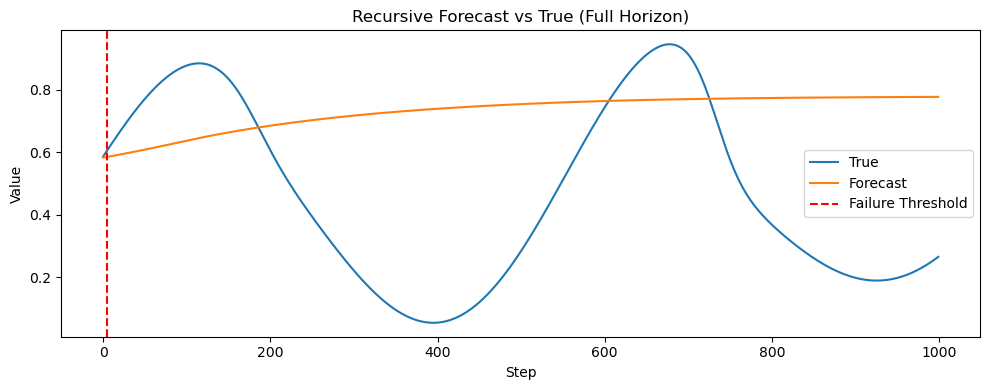

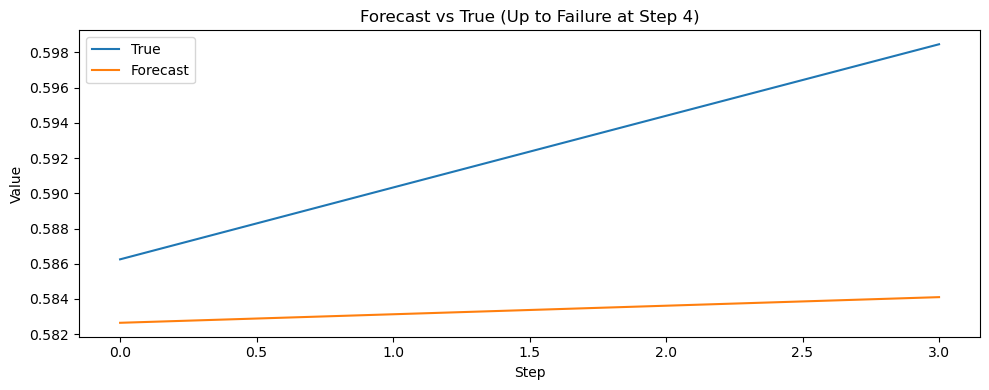

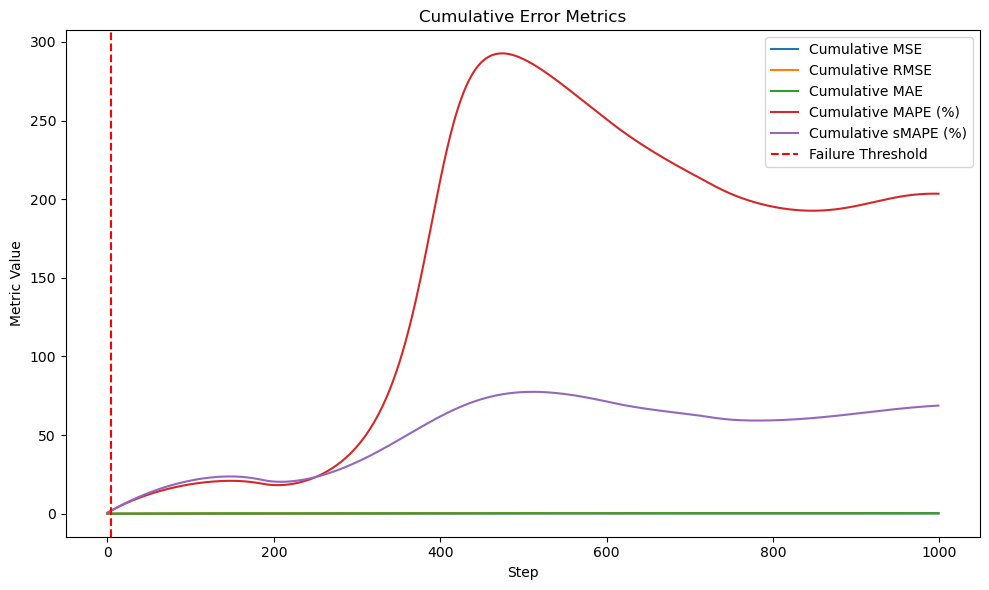

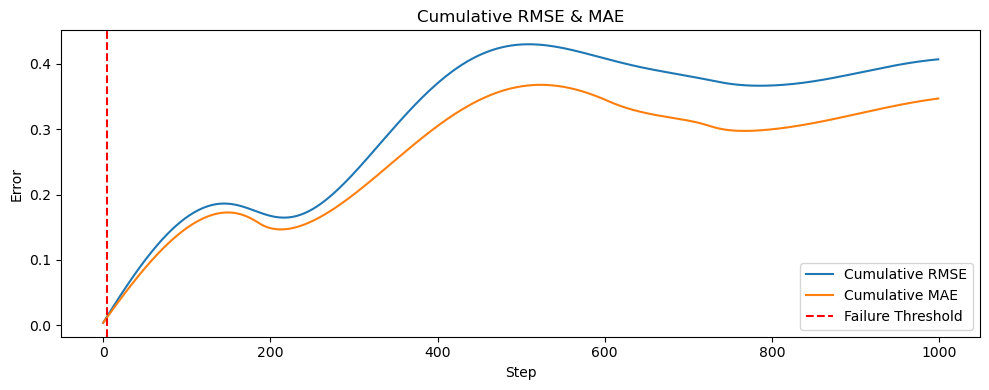

Cell end:   2025-07-04 21:47:50.220386


In [112]:
from datetime import datetime

print("Cell start:", datetime.now())

failure_step, summary = recursive_forecast_evaluate(
    model, train_data, test_data, n_steps, n_features, threshold=0.01
)

print("Cell end:  ", datetime.now())

In [113]:
print(summary)

{'final_MSE': 0.1657261075828495, 'final_RMSE': 0.4070947157392853, 'final_MAE': 0.34703665612551093, 'final_MAPE': 203.45231691475917, 'final_sMAPE': 68.74556337848982, 'error_variance': 0.045291666888073574, 'error_skewness': 0.04746336276582799, 'error_kurtosis': -1.447659097930169, 'r2_score': -0.9985435114778434, 'failure_step': 4}


## Univariate One Step, rounding the data

### Data

In [38]:
rossler_sample_1

,x
0,0.100000
1,0.097913
2,0.095850
3,0.093809
4,0.091790
...,...
9995,-3.812888
9996,-3.773334
9997,-3.733280
9998,-3.692730


In [39]:
# Count decimal digits per value
decimal_lengths = rossler_sample_1['x'].apply(lambda v: len(str(v).split('.')[-1]) if '.' in str(v) else 0)

# Check if all are the same
unique_lengths = decimal_lengths.unique()

print("Unique decimal lengths:", unique_lengths)

if len(unique_lengths) == 1:
    print(f"✅ All values have {unique_lengths[0]} digits after the decimal.")
else:
    print("❌ Values have varying decimal lengths.")

Unique decimal lengths: [ 1 15 16 14 13 12]
❌ Values have varying decimal lengths.


In [ ]:
import numpy as np
import pandas as pd

def truncate_series(s, decimals=3):
    
    factor = 10 ** decimals
    # floor for positive, ceil for negative values
    return np.floor(s * factor) / factor

In [ ]:
# df['x_trunc3'] = truncate_series(df['x'], decimals=3)
# df['x_trunc5'] = truncate_series(df['x'], decimals=5)
# df['x_round3'] = df['x'].round(3)
# df['x_round5'] = df['x'].round(5)

In [44]:
rossler_sample_1_truncated = pd.DataFrame()
rossler_sample_1_truncated['x']= truncate_series(rossler_sample_1['x'], decimals=5)

(-5.0, -4.0)

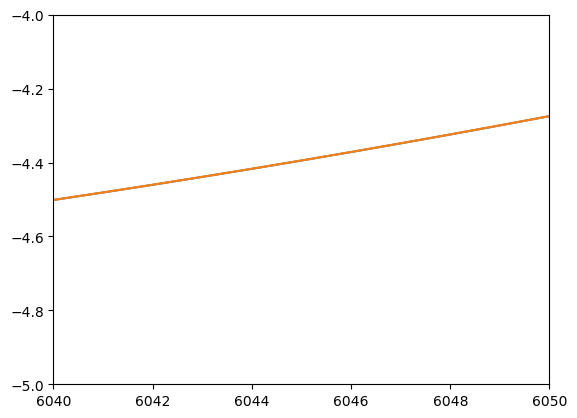

In [54]:
plt.plot(rossler_sample_1['x'].values)
plt.plot(rossler_sample_1_truncated['x'].values)
plt.xlim(6040,6050)
plt.ylim(-5,-4)

In [55]:
# Apply a MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rossler_sample_1_tr_scaled = pd.DataFrame(scaler.fit_transform(rossler_sample_1_truncated ), columns = ['x'])

In [56]:
Full = rossler_sample_1_tr_scaled['x'].values

In [57]:
n_samples = len(Full)
train_size = int(0.90 * n_samples)

train_data = Full[:train_size]
test_data = Full[train_size:]


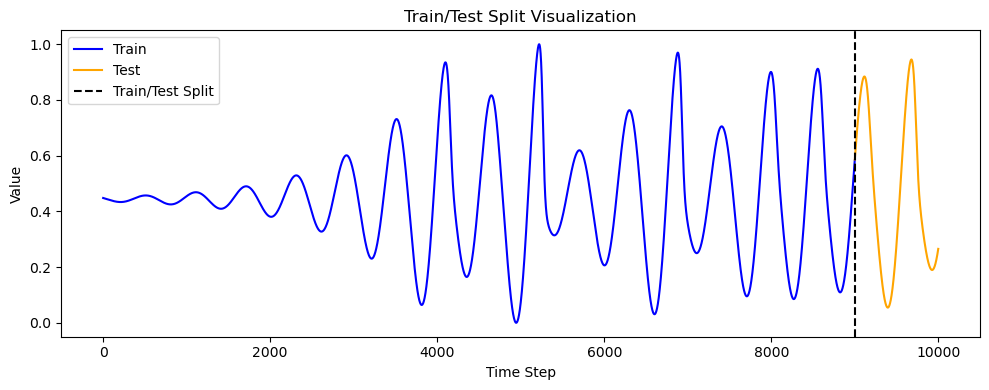

In [58]:
# Define x-axis ranges based on the lengths
train_end = len(train_data)
x_train = np.arange(train_end)
x_test = np.arange(train_end, train_end + len(test_data))
# Plot
plt.figure(figsize=(10, 4))
plt.plot(x_train, train_data, label='Train', color='blue')
plt.plot(x_test, test_data, label='Test', color='orange')

# Optional vertical line to indicate the split
plt.axvline(x=train_end, color='black', linestyle='--', label='Train/Test Split')

plt.legend()
plt.title("Train/Test Split Visualization")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

In [59]:
# choose a number of time steps
n_steps = 1
# split into samples
X, y = split_sequence(train_data, n_steps)   

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

### Model

In [60]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

In [61]:
# define model
model = Sequential()
model.add(Conv1D(64, kernel_size=1, activation = 'relu', input_shape=(n_steps, n_features)))
#model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/home/think/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [62]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
]

In [63]:
history = model.fit(X, y,
                    epochs=300,
                    batch_size=64,
                    validation_split=0.1,
                    shuffle=False,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1374 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 2/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7269e-04 - val_loss: 1.5694e-04 - learning_rate: 0.0010
Epoch 3/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4916e-05 - val_loss: 2.6591e-05 - learning_rate: 0.0010
Epoch 4/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2679e-05 - val_loss: 2.1679e-05 - learning_rate: 0.0010
Epoch 5/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8589e-05 - val_loss: 2.2382e-05 - learning_rate: 0.0010
Epoch 6/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2228e-05 - val_loss: 1.8074e-05 - learning_rate: 0.0010
Epoch 7/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6006e-05 - val_loss: 1.3424e-05 - learning_rate: 0.0010
Epoch 8/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2119e-05 - val_loss: 1.1146e-05 - learning_rate: 0.0010
Epoch 9/300
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

In [66]:
save_experiment(
  model, history,
  name="CNN_OS_UV_1_SCALEDDATA",
  save_dir="/home/think/Desktop/MODELS",
  use_h5=False
)

[+] Saved Keras model to CNN_OS_UV_1_SCALEDDATA.keras


(PosixPath('/home/think/Desktop/MODELS/CNN_OS_UV_1_SCALEDDATA'),
 PosixPath('/home/think/Desktop/MODELS/CNN_OS_UV_1_SCALEDDATA/CNN_OS_UV_1_SCALEDDATA.keras'))

In [68]:
# /home/think/Desktop/MODELS/CNN_OS_UV_1_SCALEDDATA
model_CNN_UV_OS_SD, history_CNN_UV_OS_SD, scaler__CNN_UV_OS_SD = reload_experiment()

[+] Loaded model from CNN_OS_UV_1_SCALEDDATA.keras
[+] Loaded history.json


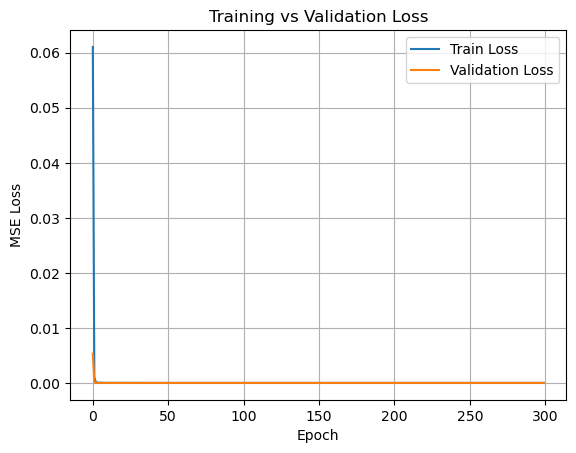

In [69]:
import matplotlib.pyplot as plt

plt.plot(history_CNN_UV_OS_SD['loss'], label='Train Loss')
plt.plot(history_CNN_UV_OS_SD['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()